This notebook is used to study model performance on the SARS-CoV-2 deep mutational scan dataset from Starr et al. (2020) https://www.cell.com/cell/fulltext/S0092-8674(20)31003-5 

In [1]:
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
from scipy import stats
from tqdm.notebook import tqdm_notebook

In [2]:
myAmino = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
FullAmino = ['ALA', 'CYS', 'ASP', 'GLU', 'PHE', 'GLY', 'HIS', 'ILE', 'LYS', 'LEU', 'MET', 'ASN', 'PRO', 'GLN', 'ARG', 'SER', 'THR', 'VAL', 'TRP', 'TYR']
aminos = {FullAmino[i]:myAmino[i] for i in range(len(myAmino))}

# zero is used as padding
AA_to_int = {'A': 1,'ALA': 1,'C': 2,'CYS': 2,'D': 3,'ASP': 3,'E': 4,'GLU': 4,'F': 5,'PHE': 5,'G': 6,'GLY': 6,'H': 7,'HIS': 7,'I': 8,'ILE': 8,'K': 9,'LYS': 9,'L': 10,'LEU': 10,'M': 11,'MET': 11,'N': 12,'ASN': 12,'P': 13,'PRO': 13,'Q': 14,'GLN': 14,'R': 15,'ARG': 15,'S': 16,'SER': 16,'T': 17,'THR': 17,'V': 18,
'VAL': 18,'W': 19,'TRP': 19,'Y': 20,'TYR': 20,'X': 21}
## amino acid to integer
atoi = {key: val - 1 for key, val in AA_to_int.items()}
## integer to amino acid
iota = {y: x for x, y in atoi.items() if len(x) == 1}

In [3]:
# def get_full_native(pdb):
#     lines = [line.rstrip('\n') for line in open(pdb)]

#     seq = []
#     index = ""
#     for l in lines:
#         sp = re.split("\s+",l)
#         if sp[0] != "ATOM":
#             continue
#         if sp[5] != index:
#             index = sp[5]
#             seq.append(aminos[sp[3]])
    
#     return "".join(seq)

def get_full_native(pdb):
    lines = [line.rstrip('\n') for line in open(pdb)]

    seq = {"A": "", "E": ""}
    index = ""
    chain = ""
    for l in lines:
        sp = re.split("\s+",l)
        if sp[0] != "ATOM":
            continue
        if sp[5] != index or sp[4] != chain:
            index = sp[5]
            chain = sp[4]
            seq[chain] += aminos[sp[3]]
    
    return seq


In [4]:
def score_sequence(seq,mat):
    sc = 0.0
    chain_size = len(seq)
    for i in range(0, chain_size):
        amino1 = atoi[seq[i]]
        for j in range(i, chain_size):
            amino2 = atoi[seq[j]]
            sc += mat[i][j][amino1][amino2]
    return sc

In [5]:
# faster scoring function than score_sequence above, because this is a deep mutational scan dataset
# so we only need to compute the energy difference caused by the point mutation

def score_point_mutation(seq, pos, mutant, mat):
    native_score = 0.0
    native_amino = atoi[seq[pos]]
    mutant_score = 0.0
    mutant_amino = atoi[mutant]

    for j in range(0, len(seq)):
        amino2 = atoi[seq[j]]
        native_score += mat[pos][j][native_amino][amino2]

    for j in range(0, len(seq)):
        amino2 = atoi[seq[j]]
        mutant_score += mat[pos][j][mutant_amino][amino2]

    return (mutant_score - native_score)

## Prepare data

In [6]:
scores = pd.read_csv("../../covid/single_mut_effects.csv", delimiter=",")

In [7]:
scores

,site_RBD,site_SARS2,wildtype,mutant,mutation,mutation_RBD,bind_lib1,bind_lib2,bind_avg,expr_lib1,expr_lib2,expr_avg
0,1,331,N,A,N331A,N1A,-0.05,-0.02,-0.03,-0.14,-0.08,-0.11
1,1,331,N,C,N331C,N1C,-0.08,-0.10,-0.09,-1.56,-0.97,-1.26
2,1,331,N,D,N331D,N1D,0.00,0.07,0.03,-0.75,-0.12,-0.44
3,1,331,N,E,N331E,N1E,0.02,-0.02,0.00,-0.39,-0.24,-0.31
4,1,331,N,F,N331F,N1F,-0.03,-0.16,-0.10,-0.83,-0.57,-0.70
...,...,...,...,...,...,...,...,...,...,...,...,...
4216,201,531,T,T,T531T,T201T,0.00,0.00,0.00,0.00,0.00,0.00
4217,201,531,T,V,T531V,T201V,0.03,-0.02,0.01,-0.07,-0.05,-0.06
4218,201,531,T,W,T531W,T201W,0.02,-0.06,-0.02,-0.13,-0.04,-0.08
4219,201,531,T,Y,T531Y,T201Y,0.00,-0.03,-0.01,-0.03,-0.08,-0.05


In [8]:
seq = get_full_native("../../covid/pdb/6m0j.pdb")
print(seq)

{'A': 'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQQNGSSVLSEDKSKRLNTILNTMSTIYSTGKVCNPDNPQECLLLEPGLNEIMANSLDYNERLWAWESWRSEVGKQLRPLYEEYVVLKNEMARANHYEDYGDYWRGDYEVNGVDGYDYSRGQLIEDVEHTFEEIKPLYEHLHAYVRAKLMNAYPSYISPIGCLPAHLLGDMWGRFWTNLYSLTVPFGQKPNIDVTDAMVDQAWDAQRIFKEAEKFFVSVGLPNMTQGFWENSMLTDPGNVQKAVCHPTAWDLGKGDFRILMCTKVTMDDFLTAHHEMGHIQYDMAYAAQPFLLRNGANEGFHEAVGEIMSLSAATPKHLKSIGLLSPDFQEDNETEINFLLKQALTIVGTLPFTYMLEKWRWMVFKGEIPKDQWMKKWWEMKREIVGVVEPVPHDETYCDPASLFHVSNDYSFIRYYTRTLYQFQFQEALCQAAKHEGPLHKCDISNSTEAGQKLFNMLRLGKSEPWTLALENVVGAKNMNVRPLLNYFEPLFTWLKDQNKNSFVGWSTDWSPYAD', 'E': 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'}


In [13]:
rbm = seq['E'][105:174]
print(rbm)
print(len(rbm))
print(len(seq['E']))

SNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQ
69
194


In [16]:
# positions 333:526 in chain E, inclusive
ace2 = seq['A']
spike = seq['E']
print(len(ace2), len(spike))

597 194


In [53]:
# include native sequence
sequences = [ace2+spike]
bindings = [0.0]

for index, row in scores.iterrows():
    if 333 <= row['site_SARS2'] <= 526 and row['wildtype'] != row['mutant'] and row['mutant'] != '*' and pd.notna(row['bind_avg']):
        newspike = spike[:(row['site_SARS2']-333)] + row['mutant'] + spike[(row['site_SARS2']-332):]
        sequences.append(ace2 + newspike)
        bindings.append(row['bind_avg'])

In [58]:
with open("allsequences.txt", "w") as f:
    for seq in sequences:
        f.write(seq+"\n")
np.savetxt("exp_bindings.csv", bindings, delimiter=',')

In [10]:
seqfile = open("allsequences.txt", "r")
sequences = [line.strip() for line in seqfile.readlines()]
seqfile.close()

In [13]:
bindings = np.genfromtxt("exp_bindings.csv", delimiter=",")

## Template for analysis

In [ ]:
pred_bindings = {}

models = ['termm','terms','coordm','coords'] # specify your models and runs here
runs = ['run0', 'run1', 'run2']
seq = ace2+spike

for m in models:
    for r in runs:
        print(m, r)
        exp_bindings = [0] # include native sequence
        pred_bindings[m] = [0]

        etab = np.load(f'../../covid/terminator_eval/triplicate/{m}/{r}/etabs/6m0j.etab.npy') # change to the correct path 
        for index, row in tqdm_notebook(scores.iterrows()):
            if 438 <= row['site_SARS2'] <= 506 and row['wildtype'] != row['mutant'] and row['mutant'] != '*' and pd.notna(row['bind_avg']):
                pos = 597 + row['site_SARS2'] - 333
                exp_bindings.append(row['bind_avg']*-1)
                mut = row['mutant']
                score = score_point_mutation(seq, pos, mut, etab)
                pred_bindings[m].append(score)

        pcor = stats.pearsonr(exp_bindings, pred_bindings[m])
        scor = stats.spearmanr(exp_bindings, pred_bindings[m])
        print(pcor)
        print(scor)
        plt.figure()
        plt.scatter(pred_bindings[m], exp_bindings, s=1)
        plt.title(f"{m}, pcor={round(pcor[0],2)}, scor={round(scor[0],2)}")
        plt.xlabel("Predicted Energy")
        plt.ylabel("Binding Affinity, Relative to Native")
        plt.show()

## Results and analysis

In [18]:
pred_bindings = {}

multi_tic_reg_0



0.5810046730037635


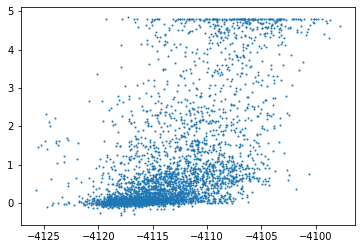

run_noreg



0.3998738489395108


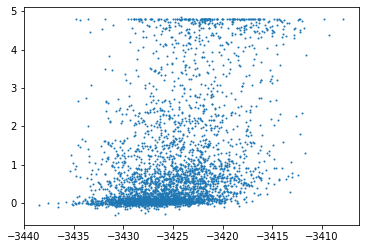

run_noreg_p1



0.590870802445491


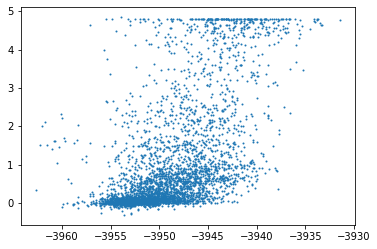

multi_tic_reg_1



0.5416869506332662


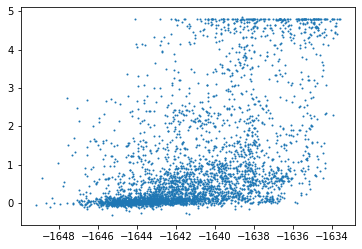

run_original



0.5199848553787039


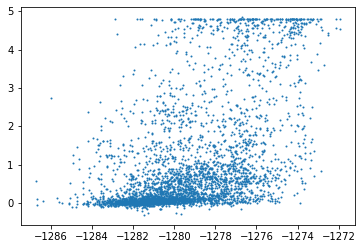

run_permute1


In [70]:
models = ['multi_tic_reg_0', 'run_noreg', 'run_noreg_p1', 'multi_tic_reg_1', 'run_original', 'run_permute1']

for m in models:
    print(m)
    pred_bindings[m] = []
    exp_bindings = np.multiply(bindings,-1)
    etab = np.load(f'../../covid/etabs/{m}/6m0j.etab.npy')
    pred_bindings[m] = [score_sequence(s, etab) for s in tqdm_notebook(sequences)]
    np.savetxt(f"{m}_bindings.csv", pred_bindings[m], delimiter=',')
    cor = np.corrcoef(exp_bindings, pred_bindings[m])[0][1]
    print(cor)
    plt.figure()
    plt.scatter(pred_bindings[m], exp_bindings, s=1)
    plt.show()

run_permute1



0.5831742089327473


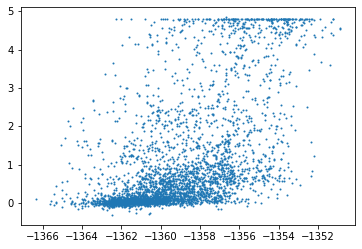

In [25]:
models = ['run_permute1']

for m in models:
    print(m)
    pred_bindings[m] = []
    exp_bindings = np.multiply(bindings,-1)
    etab = np.load(f'../../covid/etabs/{m}/6m0j.etab.npy')
    pred_bindings[m] = [score_sequence(s, etab) for s in tqdm_notebook(sequences)]
    np.savetxt(f"{m}_bindings.csv", pred_bindings[m], delimiter=',')
    cor = np.corrcoef(exp_bindings, pred_bindings[m])[0][1]
    print(cor)
    plt.figure()
    plt.scatter(pred_bindings[m], exp_bindings, s=1)
    plt.show()

In [68]:
np.multiply(bindings,-1)

array([-0.  ,  0.01,  0.14, ...,  0.04,  0.08,  0.02])

In [26]:
from scipy import stats
for i in ['multi_tic_reg_0', 'run_noreg', 'run_noreg_p1', 'multi_tic_reg_1', 'run_original', 'run_permute1']:
    print(i)
    pred_bindings_i = np.genfromtxt(f'{i}_bindings.csv')
    print(stats.pearsonr(np.multiply(bindings,-1), pred_bindings_i))
    print(stats.spearmanr(np.multiply(bindings,-1), pred_bindings_i))

multi_tic_reg_0
(0.5810046730037637, 0.0)
SpearmanrResult(correlation=0.6300192613449616, pvalue=0.0)
run_noreg
(0.3998738489395106, 5.508548668895702e-141)
SpearmanrResult(correlation=0.43363497747113006, pvalue=3.7091574399391533e-168)
run_noreg_p1
(0.5908708024454907, 0.0)
SpearmanrResult(correlation=0.6398952207023372, pvalue=0.0)
multi_tic_reg_1
(0.5416869506332658, 5.5233678072849055e-279)
SpearmanrResult(correlation=0.604100284846936, pvalue=0.0)
run_original
(0.5199848553787034, 2.0804156194616838e-253)
SpearmanrResult(correlation=0.5713772572685827, pvalue=3.68838e-317)
run_permute1
(0.5831742089327471, 0.0)
SpearmanrResult(correlation=0.6360306064373855, pvalue=0.0)


multi_tic_reg_0



(0.582322297809507, 0.0)
SpearmanrResult(correlation=0.6317774400113043, pvalue=0.0)


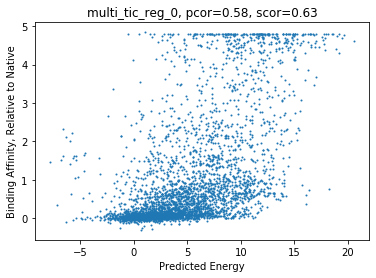

run_noreg



(0.40008166135899803, 3.8298752451637884e-141)
SpearmanrResult(correlation=0.4325348000821625, pvalue=3.196081804089899e-167)


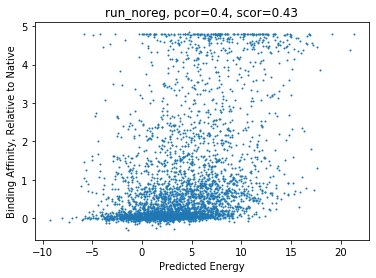

run_noreg_p1



(0.5919426944986936, 0.0)
SpearmanrResult(correlation=0.6413131228687189, pvalue=0.0)


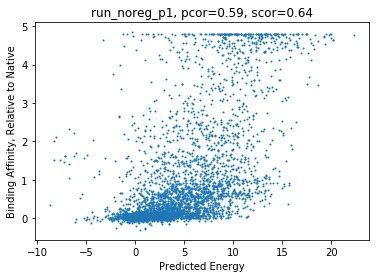

multi_tic_reg_1



(0.5432523024419786, 6.671214349707558e-281)
SpearmanrResult(correlation=0.6018914311714094, pvalue=0.0)


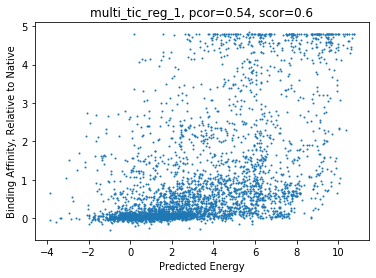

run_original



(0.5203799955242213, 7.394722177041389e-254)
SpearmanrResult(correlation=0.5696893094656048, pvalue=6.959457353e-315)


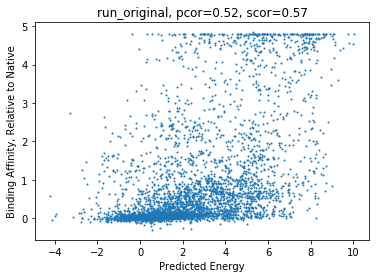

run_permute1



(0.5831042131489163, 0.0)
SpearmanrResult(correlation=0.6332514203104693, pvalue=0.0)


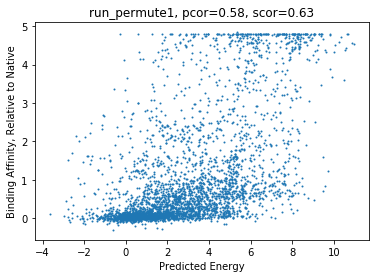

In [24]:
models = ['multi_tic_reg_0', 'run_noreg', 'run_noreg_p1', 'multi_tic_reg_1', 'run_original', 'run_permute1']
seq = ace2+spike

for m in models:
    print(m)
    exp_bindings = [0] # include native sequence
    pred_bindings[m] = [0]
    
    etab = np.load(f'../../covid/etabs/{m}/6m0j.etab.npy')
    for index, row in tqdm_notebook(scores.iterrows()):
        if 333 <= row['site_SARS2'] <= 526 and row['wildtype'] != row['mutant'] and row['mutant'] != '*' and pd.notna(row['bind_avg']):
            pos = 597 + row['site_SARS2'] - 333
            exp_bindings.append(row['bind_avg']*-1)
            mut = row['mutant']
            score = score_point_mutation(seq, pos, mut, etab)
            pred_bindings[m].append(score)

    # print(len(exp_bindings))
    # exp_bindings = np.multiply(bindings,-1)
    # pred_bindings[m] = [score_sequence(s, etab) for s in tqdm_notebook(sequences)]
    # np.savetxt(f"{m}_bindings.csv", pred_bindings[m], delimiter=',')
    # cor = np.corrcoef(exp_bindings, pred_bindings[m])[0][1]
    # print(cor)

    pcor = stats.pearsonr(exp_bindings, pred_bindings[m])
    scor = stats.spearmanr(exp_bindings, pred_bindings[m])
    print(pcor)
    print(scor)
    plt.figure()
    plt.scatter(pred_bindings[m], exp_bindings, s=1)
    plt.title(f"{m}, pcor={round(pcor[0],2)}, scor={round(scor[0],2)}")
    plt.xlabel("Predicted Energy")
    plt.ylabel("Binding Affinity, Relative to Native")
    plt.show()

multi_noreg_p0



(0.5600906774646235, 3.4358510321593795e-302)
SpearmanrResult(correlation=0.5704270349473042, pvalue=7.0725946e-316)


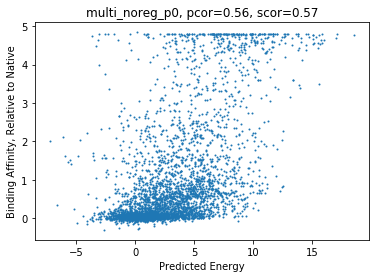

multi_noreg_p1



(0.5971796495447016, 0.0)
SpearmanrResult(correlation=0.6399649765587564, pvalue=0.0)


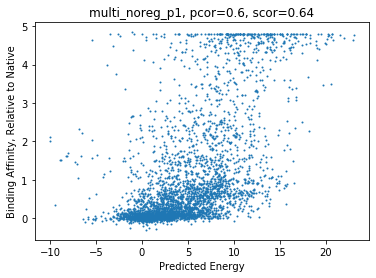

multi_reg_p0



(0.5213536335979544, 5.747399702284783e-255)
SpearmanrResult(correlation=0.5242581979531924, pvalue=2.680333770035453e-258)


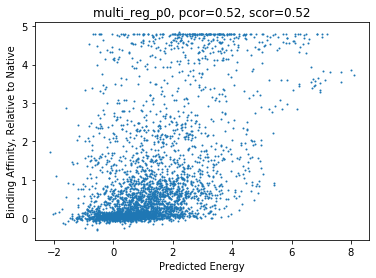

multi_reg_p1



(0.5677962803122403, 2.394116340347e-312)
SpearmanrResult(correlation=0.6032397666101277, pvalue=0.0)


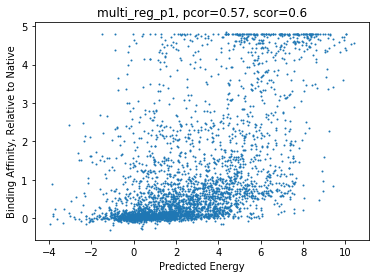

single_noreg_p0



(0.5259875152059572, 2.6876156049413272e-260)
SpearmanrResult(correlation=0.5369804047553981, pvalue=2.808087067511005e-273)


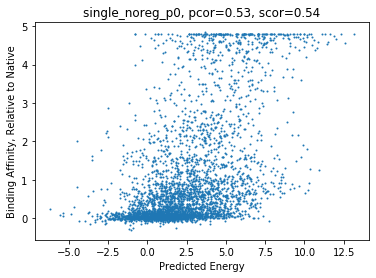

single_noreg_p1



(0.5938412379145891, 0.0)
SpearmanrResult(correlation=0.6221812451778433, pvalue=0.0)


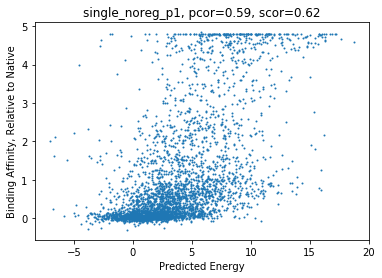

In [21]:
models = ['multi_noreg_p0', 'multi_noreg_p1', 'multi_reg_p0', 'multi_reg_p1', 'single_noreg_p0', 'single_noreg_p1']
seq = ace2+spike

for m in models:
    print(m)
    exp_bindings = [0] # include native sequence
    pred_bindings[m] = [0]
    
    etab = np.load(f'../../covid/etabs/only/only_{m}/6m0j.etab.npy')
    for index, row in tqdm_notebook(scores.iterrows()):
        if 333 <= row['site_SARS2'] <= 526 and row['wildtype'] != row['mutant'] and row['mutant'] != '*' and pd.notna(row['bind_avg']):
            pos = 597 + row['site_SARS2'] - 333
            exp_bindings.append(row['bind_avg']*-1)
            mut = row['mutant']
            score = score_point_mutation(seq, pos, mut, etab)
            pred_bindings[m].append(score)

    # print(len(exp_bindings))
    # exp_bindings = np.multiply(bindings,-1)
    # pred_bindings[m] = [score_sequence(s, etab) for s in tqdm_notebook(sequences)]
    # np.savetxt(f"{m}_bindings.csv", pred_bindings[m], delimiter=',')
    # cor = np.corrcoef(exp_bindings, pred_bindings[m])[0][1]
    # print(cor)

    pcor = stats.pearsonr(exp_bindings, pred_bindings[m])
    scor = stats.spearmanr(exp_bindings, pred_bindings[m])
    print(pcor)
    print(scor)
    plt.figure()
    plt.scatter(pred_bindings[m], exp_bindings, s=1)
    plt.title(f"{m}, pcor={round(pcor[0],2)}, scor={round(scor[0],2)}")
    plt.xlabel("Predicted Energy")
    plt.ylabel("Binding Affinity, Relative to Native")
    plt.show()

ingraham


0it [00:00, ?it/s]

(0.5757795833295563, 4e-323)
SpearmanrResult(correlation=0.640096795416968, pvalue=0.0)


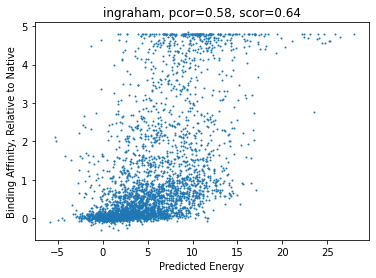

In [15]:
models = ['ingraham']
seq = ace2+spike

for m in models:
    print(m)
    exp_bindings = [0] # include native sequence
    pred_bindings[m] = [0]
    
    etab = np.load(f'../../covid/eval/{m}/etabs/6m0j.etab.npy')
    for index, row in tqdm_notebook(scores.iterrows()):
        if 333 <= row['site_SARS2'] <= 526 and row['wildtype'] != row['mutant'] and row['mutant'] != '*' and pd.notna(row['bind_avg']):
            pos = 597 + row['site_SARS2'] - 333
            exp_bindings.append(row['bind_avg']*-1)
            mut = row['mutant']
            score = score_point_mutation(seq, pos, mut, etab)
            pred_bindings[m].append(score)

    pcor = stats.pearsonr(exp_bindings, pred_bindings[m])
    scor = stats.spearmanr(exp_bindings, pred_bindings[m])
    print(pcor)
    print(scor)
    plt.figure()
    plt.scatter(pred_bindings[m], exp_bindings, s=1)
    plt.title(f"{m}, pcor={round(pcor[0],2)}, scor={round(scor[0],2)}")
    plt.xlabel("Predicted Energy")
    plt.ylabel("Binding Affinity, Relative to Native")
    plt.show()

term_m run0


0it [00:00, ?it/s]

(0.5466080591563407, 4.765382892042483e-285)
SpearmanrResult(correlation=0.6027697135511766, pvalue=0.0)


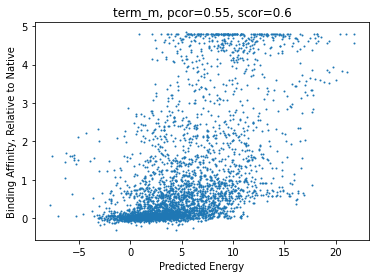

term_m run1


0it [00:00, ?it/s]

(0.5759830743246719, 2e-323)
SpearmanrResult(correlation=0.6372140530416234, pvalue=0.0)


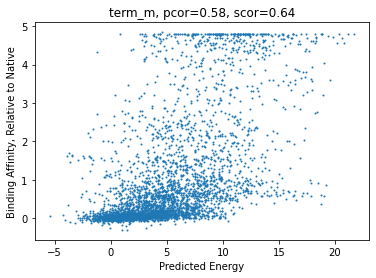

term_m run2


0it [00:00, ?it/s]

(0.5480756419638863, 7.079758368800044e-287)
SpearmanrResult(correlation=0.6236841602343656, pvalue=0.0)


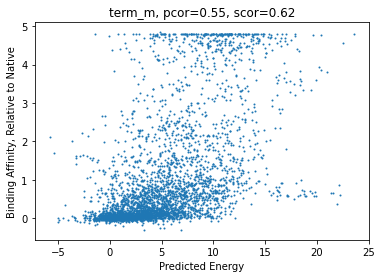

term_s run0


0it [00:00, ?it/s]

(0.5834910691666104, 0.0)
SpearmanrResult(correlation=0.6682586652461862, pvalue=0.0)


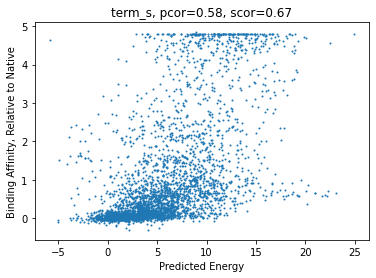

term_s run1


0it [00:00, ?it/s]

(0.6182541898922742, 0.0)
SpearmanrResult(correlation=0.6730612728010595, pvalue=0.0)


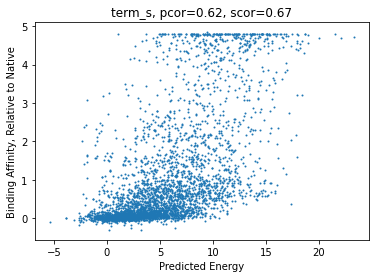

term_s run2


0it [00:00, ?it/s]

(0.5580377234276934, 1.5748018882888427e-299)
SpearmanrResult(correlation=0.6489830952229473, pvalue=0.0)


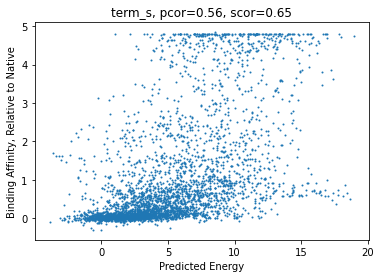

coord_m run0


0it [00:00, ?it/s]

(0.5838136707471061, 0.0)
SpearmanrResult(correlation=0.6163643596500114, pvalue=0.0)


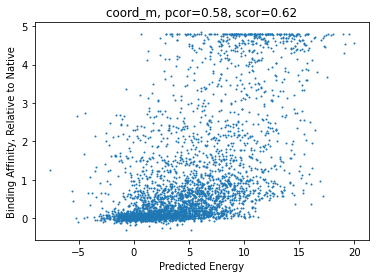

coord_m run1


0it [00:00, ?it/s]

(0.5879030620998813, 0.0)
SpearmanrResult(correlation=0.6367255333441361, pvalue=0.0)


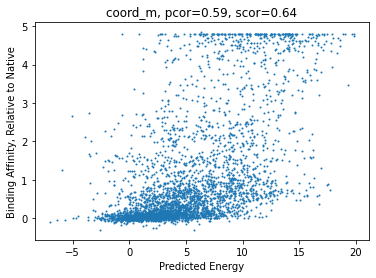

coord_m run2


0it [00:00, ?it/s]

(0.5674796789968477, 6.33531486207e-312)
SpearmanrResult(correlation=0.6210137436572544, pvalue=0.0)


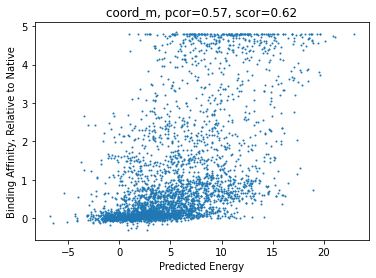

coord_s run0


0it [00:00, ?it/s]

(0.5757795833295563, 4e-323)
SpearmanrResult(correlation=0.640096795416968, pvalue=0.0)


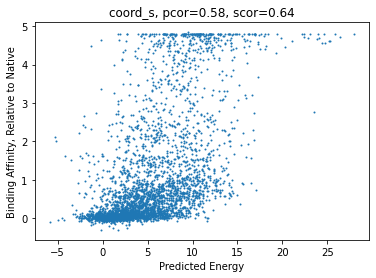

coord_s run1


0it [00:00, ?it/s]

(0.5757759805329615, 4e-323)
SpearmanrResult(correlation=0.6441486538266702, pvalue=0.0)


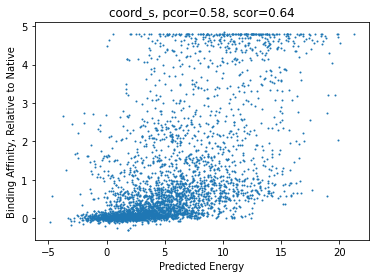

coord_s run2


0it [00:00, ?it/s]

(0.611213686146399, 0.0)
SpearmanrResult(correlation=0.6694439556737046, pvalue=0.0)


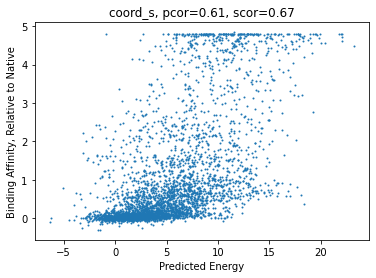

f_term_m run0


0it [00:00, ?it/s]

(0.5666656536949717, 7.6963226277873e-311)
SpearmanrResult(correlation=0.6109596712623215, pvalue=0.0)


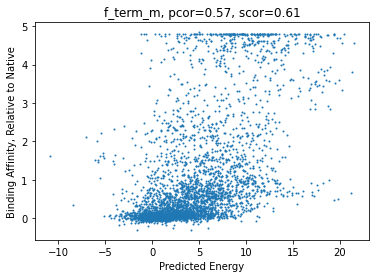

f_term_m run1


0it [00:00, ?it/s]

(0.5663050941947332, 2.3210507916924e-310)
SpearmanrResult(correlation=0.6171470963188743, pvalue=0.0)


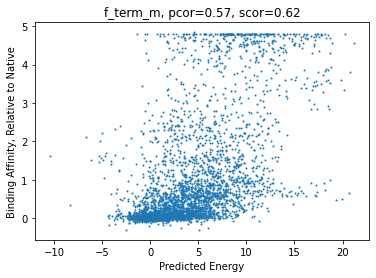

f_term_m run2


0it [00:00, ?it/s]

(0.5664178398240549, 1.6437709952758e-310)
SpearmanrResult(correlation=0.6148318267632766, pvalue=0.0)


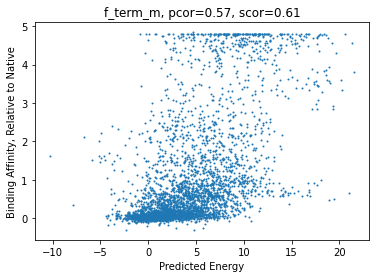

f_term_s run0


0it [00:00, ?it/s]

(0.5828463065396678, 0.0)
SpearmanrResult(correlation=0.6406143885014907, pvalue=0.0)


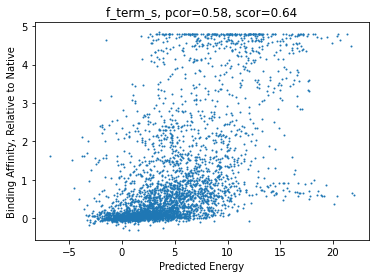

f_term_s run1


0it [00:00, ?it/s]

(0.5859224729018793, 0.0)
SpearmanrResult(correlation=0.6386421232457709, pvalue=0.0)


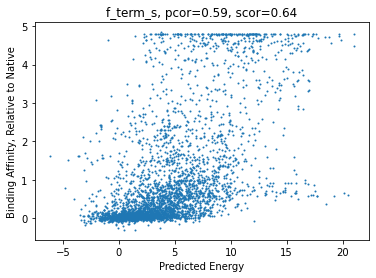

f_term_s run2


0it [00:00, ?it/s]

(0.5796924800097807, 0.0)
SpearmanrResult(correlation=0.6337774179709897, pvalue=0.0)


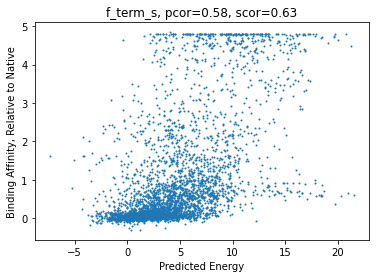

f_coord_s_reg run0


0it [00:00, ?it/s]

(0.5514606748045546, 3.968716166811187e-291)
SpearmanrResult(correlation=0.6052711447989477, pvalue=0.0)


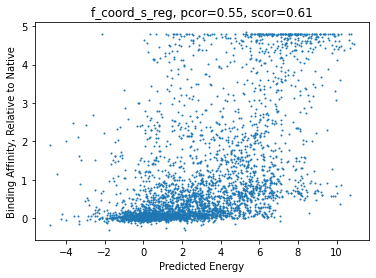

f_coord_s_reg run1


0it [00:00, ?it/s]

(0.5570054090382636, 3.3757073294173944e-298)
SpearmanrResult(correlation=0.6096242214643567, pvalue=0.0)


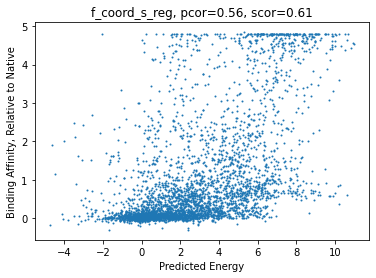

f_coord_s_reg run2


0it [00:00, ?it/s]

(0.5579788076454201, 1.8763860273963315e-299)
SpearmanrResult(correlation=0.6082695792250119, pvalue=0.0)


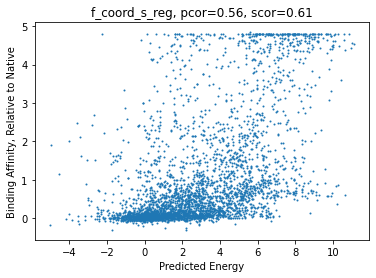

In [17]:
models = ['term_m','term_s','coord_m','coord_s','f_term_m','f_term_s','f_coord_s_reg']
runs = ['run0', 'run1', 'run2']
seq = ace2+spike

for m in models:
    for r in runs:
        print(m, r)
        exp_bindings = [0] # include native sequence
        pred_bindings[m] = [0]

        etab = np.load(f'../../covid/terminator_eval/{m}/{r}/etabs/6m0j.etab.npy')
        for index, row in tqdm_notebook(scores.iterrows()):
            if 333 <= row['site_SARS2'] <= 526 and row['wildtype'] != row['mutant'] and row['mutant'] != '*' and pd.notna(row['bind_avg']):
                pos = 597 + row['site_SARS2'] - 333
                exp_bindings.append(row['bind_avg']*-1)
                mut = row['mutant']
                score = score_point_mutation(seq, pos, mut, etab)
                pred_bindings[m].append(score)

        pcor = stats.pearsonr(exp_bindings, pred_bindings[m])
        scor = stats.spearmanr(exp_bindings, pred_bindings[m])
        print(pcor)
        print(scor)
        plt.figure()
        plt.scatter(pred_bindings[m], exp_bindings, s=1)
        plt.title(f"{m}, pcor={round(pcor[0],2)}, scor={round(scor[0],2)}")
        plt.xlabel("Predicted Energy")
        plt.ylabel("Binding Affinity, Relative to Native")
        plt.show()

termm run0



(0.5632131997062353, 2.834297182354108e-306)
SpearmanrResult(correlation=0.6076322608401483, pvalue=0.0)


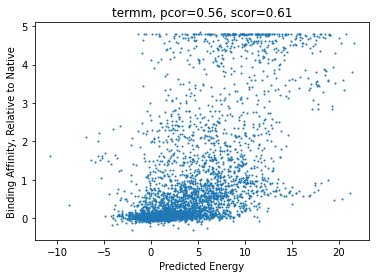

termm run1



(0.5757041091246851, 5e-323)
SpearmanrResult(correlation=0.6215773532975899, pvalue=0.0)


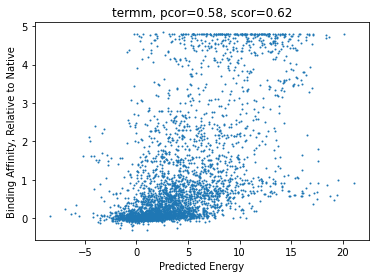

termm run2



(0.5745321832134636, 1.897e-321)
SpearmanrResult(correlation=0.6155441609204688, pvalue=0.0)


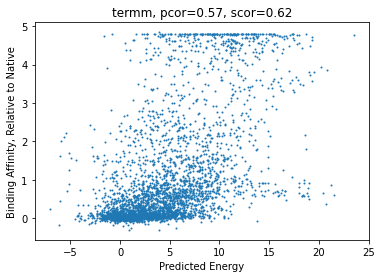

terms run0



(0.581598520226478, 0.0)
SpearmanrResult(correlation=0.6442256606707906, pvalue=0.0)


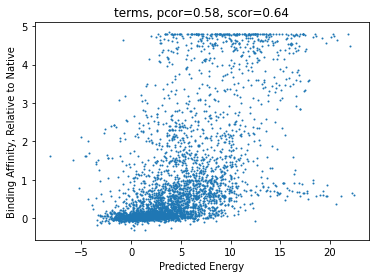

terms run1



(0.5942317573228793, 0.0)
SpearmanrResult(correlation=0.6473999926087887, pvalue=0.0)


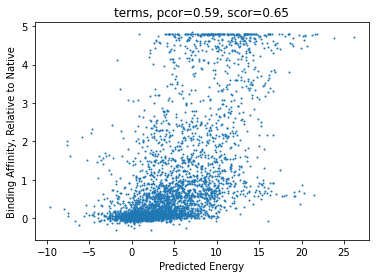

terms run2



(0.5777818749743867, 0.0)
SpearmanrResult(correlation=0.6455989107275821, pvalue=0.0)


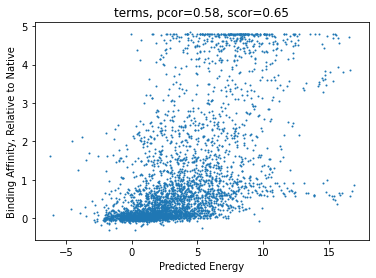

coordm run0



(0.5992793060069095, 0.0)
SpearmanrResult(correlation=0.6168561059471954, pvalue=0.0)


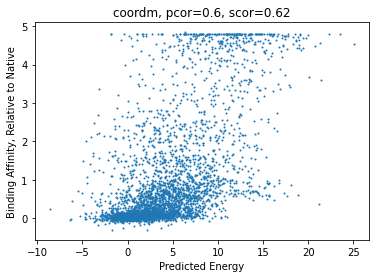

coordm run1



(0.5761130673629385, 1e-323)
SpearmanrResult(correlation=0.6334010382725394, pvalue=0.0)


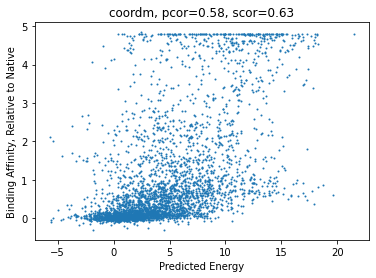

coordm run2



(0.5822844018854401, 0.0)
SpearmanrResult(correlation=0.6255424816057404, pvalue=0.0)


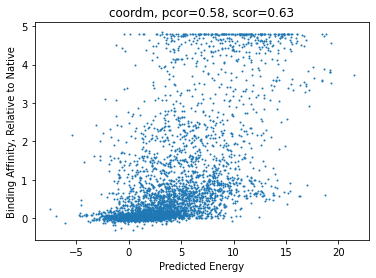

coords run0



(0.5876102818717446, 0.0)
SpearmanrResult(correlation=0.6198935850216084, pvalue=0.0)


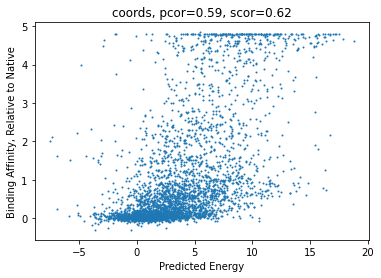

coords run1



(0.5881559537475594, 0.0)
SpearmanrResult(correlation=0.6364922430239218, pvalue=0.0)


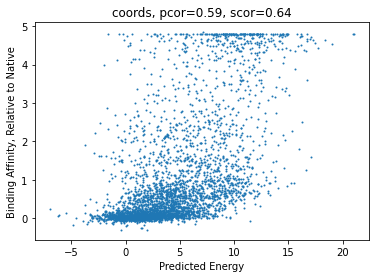

coords run2



(0.6008793694222427, 0.0)
SpearmanrResult(correlation=0.6679790658154087, pvalue=0.0)


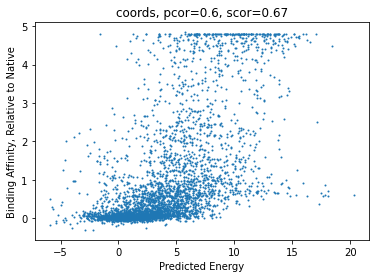

In [22]:
models = ['termm','terms','coordm','coords']
runs = ['run0', 'run1', 'run2']
seq = ace2+spike

for m in models:
    for r in runs:
        print(m, r)
        exp_bindings = [0] # include native sequence
        pred_bindings[m] = [0]

        etab = np.load(f'../../covid/terminator_eval/triplicate/{m}/{r}/etabs/6m0j.etab.npy')
        for index, row in tqdm_notebook(scores.iterrows()):
            if 333 <= row['site_SARS2'] <= 526 and row['wildtype'] != row['mutant'] and row['mutant'] != '*' and pd.notna(row['bind_avg']):
                pos = 597 + row['site_SARS2'] - 333
                exp_bindings.append(row['bind_avg']*-1)
                mut = row['mutant']
                score = score_point_mutation(seq, pos, mut, etab)
                pred_bindings[m].append(score)

        pcor = stats.pearsonr(exp_bindings, pred_bindings[m])
        scor = stats.spearmanr(exp_bindings, pred_bindings[m])
        print(pcor)
        print(scor)
        plt.figure()
        plt.scatter(pred_bindings[m], exp_bindings, s=1)
        plt.title(f"{m}, pcor={round(pcor[0],2)}, scor={round(scor[0],2)}")
        plt.xlabel("Predicted Energy")
        plt.ylabel("Binding Affinity, Relative to Native")
        plt.show()

term_m run0



(0.468619726806086, 1.372198060233826e-72)
SpearmanrResult(correlation=0.48272474196754145, pvalue=1.5516966134077994e-77)


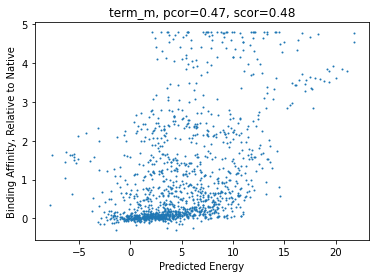

term_m run1



(0.5204811616292211, 5.639361467917389e-92)
SpearmanrResult(correlation=0.5274853542397324, pvalue=7.364311828964974e-95)


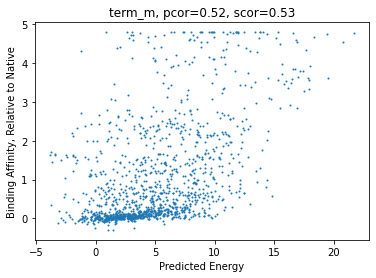

term_m run2



(0.47052270281617486, 3.0442474839881355e-73)
SpearmanrResult(correlation=0.49568352620279343, pvalue=2.738945369656268e-82)


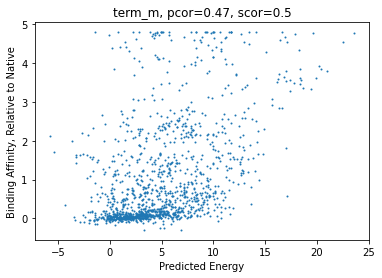

term_s run0



(0.5107532836044747, 4.4323901155851826e-88)
SpearmanrResult(correlation=0.5483534564170608, pvalue=7.268716978565541e-104)


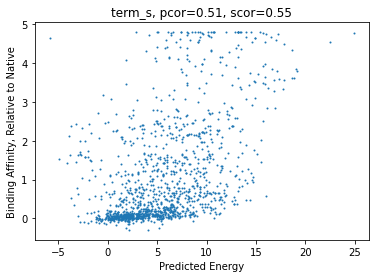

term_s run1



(0.5413470359746935, 9.034154429075168e-101)
SpearmanrResult(correlation=0.5628367780283559, pvalue=1.687022651469279e-110)


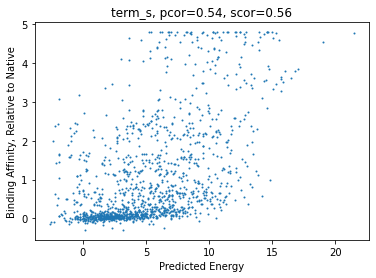

term_s run2



(0.5160472818126564, 3.4865420035234763e-90)
SpearmanrResult(correlation=0.5478047282819484, pvalue=1.2777882965322766e-103)


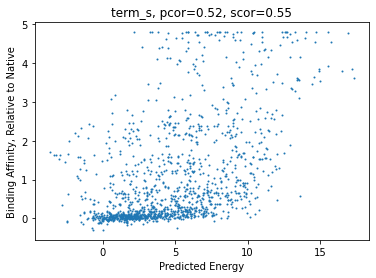

coord_m run0



(0.4779228548703175, 7.959307371951417e-76)
SpearmanrResult(correlation=0.5104545469573251, pvalue=5.811347334663476e-88)


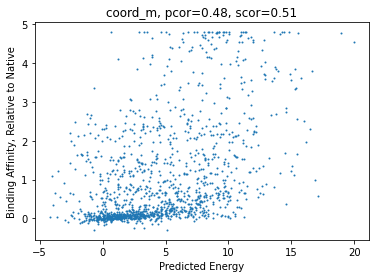

coord_m run1



(0.4811743741668834, 5.570711359216958e-77)
SpearmanrResult(correlation=0.5119894277184297, pvalue=1.440834094331628e-88)


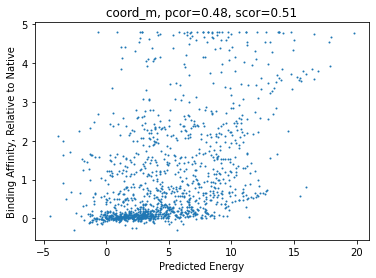

coord_m run2



(0.4885727336754784, 1.1778022055308886e-79)
SpearmanrResult(correlation=0.5129872521889056, pvalue=5.7970859809976056e-89)


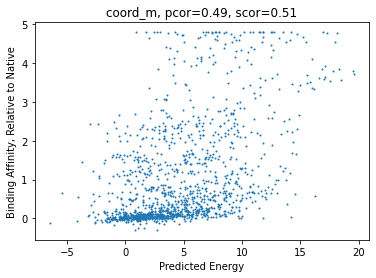

coord_s run0



(0.46727425611566165, 3.956270737527738e-72)
SpearmanrResult(correlation=0.5567941528141954, pvalue=1.0834631598162762e-107)


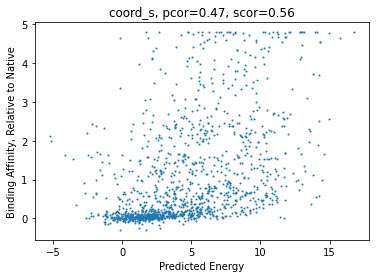

coord_s run1



(0.48367893310146387, 7.042715354355299e-78)
SpearmanrResult(correlation=0.5346743256877751, pvalue=6.85146410332682e-98)


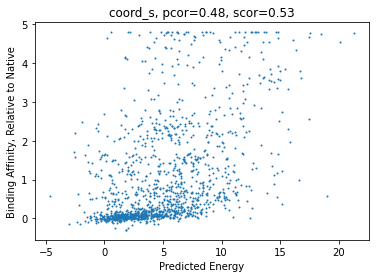

coord_s run2



(0.5294864198250724, 1.0731792938295012e-95)
SpearmanrResult(correlation=0.5614997580135995, pvalue=7.13440759707429e-110)


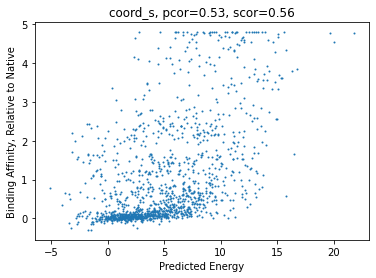

In [20]:
models = ['term_m','term_s','coord_m','coord_s']
runs = ['run0', 'run1', 'run2']
seq = ace2+spike

for m in models:
    for r in runs:
        print(m, r)
        exp_bindings = [0] # include native sequence
        pred_bindings[m] = [0]

        etab = np.load(f'../../covid/terminator_eval/{m}/{r}/etabs/6m0j.etab.npy')
        for index, row in tqdm_notebook(scores.iterrows()):
            if 438 <= row['site_SARS2'] <= 506 and row['wildtype'] != row['mutant'] and row['mutant'] != '*' and pd.notna(row['bind_avg']):
                pos = 597 + row['site_SARS2'] - 333
                exp_bindings.append(row['bind_avg']*-1)
                mut = row['mutant']
                score = score_point_mutation(seq, pos, mut, etab)
                pred_bindings[m].append(score)

        pcor = stats.pearsonr(exp_bindings, pred_bindings[m])
        scor = stats.spearmanr(exp_bindings, pred_bindings[m])
        print(pcor)
        print(scor)
        plt.figure()
        plt.scatter(pred_bindings[m], exp_bindings, s=1)
        plt.title(f"{m}, pcor={round(pcor[0],2)}, scor={round(scor[0],2)}")
        plt.xlabel("Predicted Energy")
        plt.ylabel("Binding Affinity, Relative to Native")
        plt.show()

termm run0



(0.472669214031456, 5.50655851219129e-74)
SpearmanrResult(correlation=0.45567382225322384, pvalue=3.0065622864029914e-68)


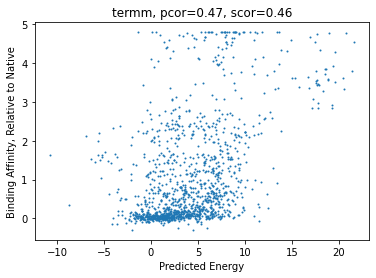

termm run1



(0.48895151489300304, 8.557591604127605e-80)
SpearmanrResult(correlation=0.4708120238782247, pvalue=2.4193330716740353e-73)


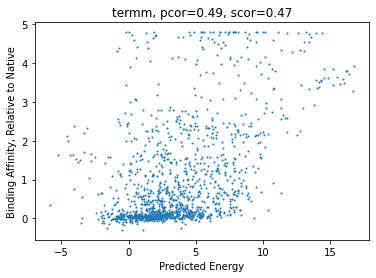

termm run2



(0.4708386107161848, 2.3687612319446496e-73)
SpearmanrResult(correlation=0.4690866181237014, pvalue=9.491983701355902e-73)


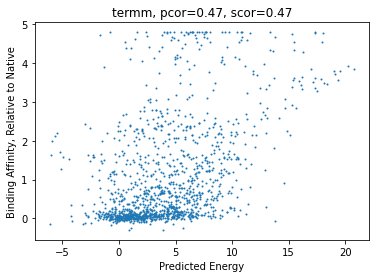

terms run0



(0.4859451925861297, 1.0680009854421237e-78)
SpearmanrResult(correlation=0.5134307025717244, pvalue=3.8642312182203894e-89)


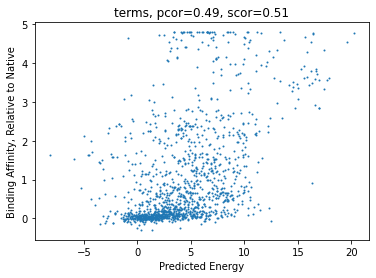

terms run1



(0.5126794921107543, 7.679003317068081e-89)
SpearmanrResult(correlation=0.5282661615789912, pvalue=3.4786896823517804e-95)


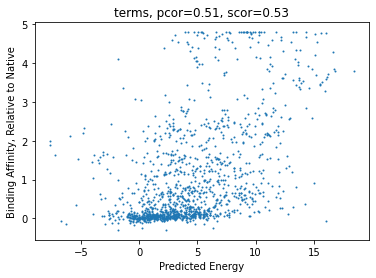

terms run2



(0.5370434598482309, 6.617169337007916e-99)
SpearmanrResult(correlation=0.5369068044037671, pvalue=7.576094255214014e-99)


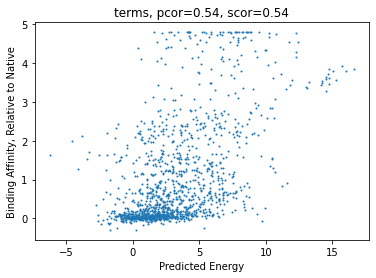

coordm run0



(0.48975023034309434, 4.357792538630779e-80)
SpearmanrResult(correlation=0.503950444165986, pvalue=1.980359628992432e-85)


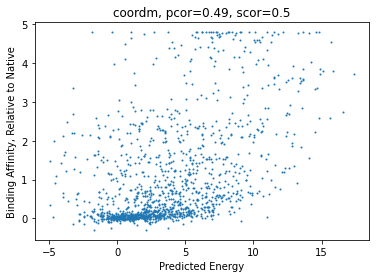

coordm run1



(0.46294904209348525, 1.1528109329326348e-70)
SpearmanrResult(correlation=0.49308421732961943, pvalue=2.555366456850473e-81)


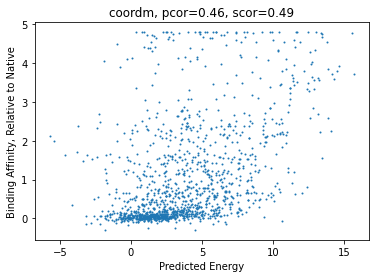

coordm run2



(0.52040408363355, 6.061696341358029e-92)
SpearmanrResult(correlation=0.5343563403266302, pvalue=9.363060500933998e-98)


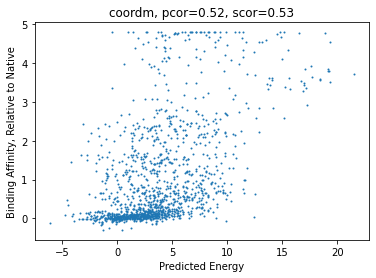

coords run0



(0.47333066125074263, 3.243246175663732e-74)
SpearmanrResult(correlation=0.49550436485127247, pvalue=3.1967005231731434e-82)


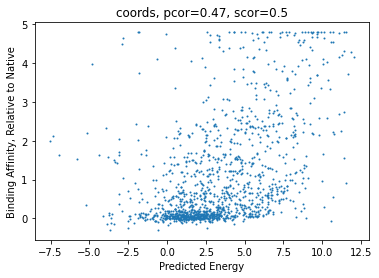

coords run1



(0.4592901099419999, 1.9244373575820974e-69)
SpearmanrResult(correlation=0.4844455140556001, pvalue=3.7268210994156355e-78)


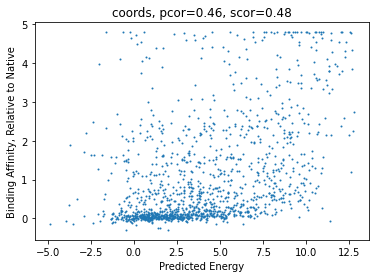

coords run2



(0.5371809119752531, 5.774697586505791e-99)
SpearmanrResult(correlation=0.6076560896085778, pvalue=2.9332116503409245e-133)


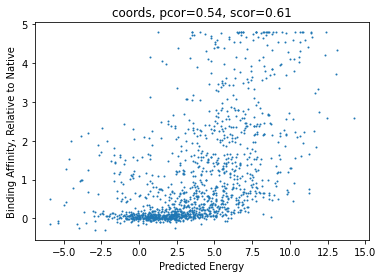

In [21]:
models = ['termm','terms','coordm','coords']
runs = ['run0', 'run1', 'run2']
seq = ace2+spike

for m in models:
    for r in runs:
        print(m, r)
        exp_bindings = [0] # include native sequence
        pred_bindings[m] = [0]

        etab = np.load(f'../../covid/terminator_eval/triplicate/{m}/{r}/etabs/6m0j.etab.npy')
        for index, row in tqdm_notebook(scores.iterrows()):
            if 438 <= row['site_SARS2'] <= 506 and row['wildtype'] != row['mutant'] and row['mutant'] != '*' and pd.notna(row['bind_avg']):
                pos = 597 + row['site_SARS2'] - 333
                exp_bindings.append(row['bind_avg']*-1)
                mut = row['mutant']
                score = score_point_mutation(seq, pos, mut, etab)
                pred_bindings[m].append(score)

        pcor = stats.pearsonr(exp_bindings, pred_bindings[m])
        scor = stats.spearmanr(exp_bindings, pred_bindings[m])
        print(pcor)
        print(scor)
        plt.figure()
        plt.scatter(pred_bindings[m], exp_bindings, s=1)
        plt.title(f"{m}, pcor={round(pcor[0],2)}, scor={round(scor[0],2)}")
        plt.xlabel("Predicted Energy")
        plt.ylabel("Binding Affinity, Relative to Native")
        plt.show()

In [14]:
rbm = seq['E'][105:174]
print(rbm)
print(len(rbm))
print(len(seq['E']))

SNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQ
69
194
